<a href="https://colab.research.google.com/github/Arthur-ca/MIE1517/blob/Jing-Guo/ExtractFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import torch
import numpy as np
import os
from sklearn.model_selection import train_test_split
import random
import torchvision
from torchvision import datasets, models
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as F1
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.datasets import ImageFolder
import tensorflow as tf
import gc
from collections import Counter
import imgaug.augmenters as iaa
import cv2
import dlib
from collections import defaultdict
from matplotlib import pyplot as plt

In [23]:
#First link it to google drive and check the subfolder of the data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
classeses = []
for i in os.listdir('/content/gdrive/My Drive/ColabNotebooks/archive'):
    if i!=5:
        classeses.append(i)
classeses

['neutrality',
 'sadness',
 'fear',
 'surprise',
 'contempt',
 'happiness',
 'anger',
 'disgust']

In [25]:
features_or = []
labels_or = []
train_data_or = []
def create_images():
    for i, photo in enumerate(classeses):
        path = os.path.join('/content/gdrive/My Drive/ColabNotebooks/archive', photo)
        label = i  # Use the index of the class as the label

        # Loop over to get every image in the current class
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)

            # Read the image using OpenCV
            img = cv2.imread(img_path)

            if img is None:
                print("Error loading image:", img_path)
                continue

            # Convert the image to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Append the original image and its label to the list
            features_or.append(gray)  # Append the grayscale image
            labels_or.append(label)

            train_data_or.append([gray, label])

# Call the function
create_images()

# Count the occurrences of each label
label_counts_or = Counter(labels_or)

# Print the label counts
for label, count in label_counts_or.items():
    print(f"Label {label}: {count} images")

Label 0: 524 images
Label 1: 746 images
Label 2: 570 images
Label 3: 785 images
Label 4: 208 images
Label 5: 1406 images
Label 6: 890 images
Label 7: 439 images


In [5]:
def extract_region(image, points):
   # Create a mask with the same dimensions as the image
   mask = np.zeros(image.shape[:2], dtype=np.uint8)
   # Fill the mask with the polygon defined by `points`
   cv2.fillPoly(mask, [points], 255)
   # Bitwise AND operation to extract the region
   extracted = cv2.bitwise_and(image, image, mask=mask)
   return extracted

# Function to combine points
def combine_points(*args):
    combined = np.vstack(args)
    return combined

# Function to extract region and place it on black background
def place_on_black(image, points):
    x, y, w, h = cv2.boundingRect(points)
    cropped = image[y:y+h, x:x+w]
    black_background = np.zeros_like(image)
    black_background[y:y+h, x:x+w] = cropped

In [21]:
def linear_normalization(image):
    # Convert image to float32 for numerical precision
    img_float = image.astype(np.float32)

    # Normalize to the range [0, 1]
    normalized_image = (img_float - np.min(img_float)) / (np.max(img_float) - np.min(img_float))

    # Convert back to uint8 format (0-255)
    normalized_image = (normalized_image * 255).astype(np.uint8)

    return normalized_image

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')
drive_content = os.listdir('/content/gdrive/My Drive/ColabNotebooks/')
print(drive_content)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['Untitled0.ipynb', 'Untitled (3)', 'coding_exercises_1_and_2.ipynb', 'Untitled (2)', 'ANN Classification with Lists.ipynb', 'ANN_2layer_example.ipynb', 'A1 (1).ipynb', 'Untitled (1)', 'A1.ipynb', 'A2_Hand_Gesture_Dataset.zip', 'Untitled', 'Lab_3b_Gesture_Dataset', 'ECE1513A1.ipynb', 'SignL', 'new', 'Feature', 'A2.ipynb', 'IMDB Dataset.csv', 'archive', 'shape_predictor_68_face_landmarks.dat']


In [7]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/gdrive/My Drive/ColabNotebooks/shape_predictor_68_face_landmarks.dat')

In [8]:

def extract_facial_regions(features, labels):
    processed_images = {'eyes': [], 'eyebrows': [], 'mouth': []}
    failed_indices = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
     # Update with your path

    for i, image in enumerate(features):
        # Convert the image to a NumPy array
        gray = np.array(image)
        gray_clahe = clahe.apply(gray)

        # Detect faces in the CLAHE preprocessed image
        faces = detector(gray_clahe, 1)

        # If no faces are detected with CLAHE, try standard histogram equalization
        if len(faces) == 0:
            gray_eq = cv2.equalizeHist(gray)
            faces = detector(gray_eq, 1)
            image_to_use = gray_eq
        else:
            image_to_use = gray_clahe

        # If faces are detected
        if len(faces) > 0:
            for rect in faces:
                # Determine the facial landmarks for the face region
                shape = predictor(image_to_use, rect)

                # Convert the facial landmarks to NumPy arrays
                left_eye = np.array([(shape.part(n).x, shape.part(n).y) for n in range(36, 42)])
                right_eye = np.array([(shape.part(n).x, shape.part(n).y) for n in range(42, 48)])
                left_eyebrow = np.array([(shape.part(n).x, shape.part(n).y) for n in range(17, 22)])
                right_eyebrow = np.array([(shape.part(n).x, shape.part(n).y) for n in range(22, 27)])
                mouth = np.array([(shape.part(n).x, shape.part(n).y) for n in range(48, 68)])

                # Extract regions
                eyes_region = extract_region(image, np.concatenate((left_eye, right_eye)))
                eyebrows_region = extract_region(image, np.concatenate((left_eyebrow, right_eyebrow)))
                mouth_region = extract_region(image, mouth)

                #linear_normalization each region

                # Append processed images and labels to the corresponding category
                processed_images['eyes'].append((eyes_region, labels[i]))
                processed_images['eyebrows'].append((eyebrows_region, labels[i]))
                processed_images['mouth'].append((mouth_region, labels[i]))

        else:
            # If no faces are detected, add the index to the failed_indices array
            failed_indices.append(i)

    return processed_images, failed_indices


In [26]:
# Extract then Normalized
def extract_facial_regions_combine(features, labels):
    processed_images = {'Processed image': []}
    failed_indices = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
     # Update with your path

    for i, image in enumerate(features):
        # Convert the image to a NumPy array
        gray = np.array(image)
        gray_clahe = clahe.apply(gray)

        # Detect faces in the CLAHE preprocessed image
        faces = detector(gray_clahe, 1)

        # If no faces are detected with CLAHE, try standard histogram equalization
        if len(faces) == 0:
            gray_eq = cv2.equalizeHist(gray)
            faces = detector(gray_eq, 1)
            image_to_use = gray_eq
        else:
            image_to_use = gray_clahe

        # If faces are detected
        if len(faces) > 0:
            for rect in faces:
                # Determine the facial landmarks for the face region
                shape = predictor(image_to_use, rect)

                # Convert the facial landmarks to NumPy arrays
                left_eye = np.array([(shape.part(n).x, shape.part(n).y) for n in range(36, 42)])
                right_eye = np.array([(shape.part(n).x, shape.part(n).y) for n in range(42, 48)])
                left_eyebrow = np.array([(shape.part(n).x, shape.part(n).y) for n in range(17, 22)])
                right_eyebrow = np.array([(shape.part(n).x, shape.part(n).y) for n in range(22, 27)])
                mouth = np.array([(shape.part(n).x, shape.part(n).y) for n in range(48, 68)])

                # Extract regions
                eyes_region = extract_region(image, np.concatenate((left_eye, right_eye)))
                eyebrows_region = extract_region(image, np.concatenate((left_eyebrow, right_eyebrow)))
                mouth_region = extract_region(image, mouth)
                # Normalize regions
                eyes_region = linear_normalization(eyes_region)
                eyebrows_region = linear_normalization(eyes_region)
                mouth_region = linear_normalization(mouth_region)

                # Resize regions to match the dimensions of the destination area
                region_height, region_width= eyes_region.shape
                eyebrows_region = cv2.resize(eyebrows_region, (region_width, int(region_height / 3)))
                eyes_region = cv2.resize(eyes_region, (region_width, int(region_height / 3)))
                mouth_region = cv2.resize(mouth_region, (region_width, int(region_height-2*int(region_height*1/3))))
                region_height, region_width= eyes_region.shape

                # Combine the extracted picture
                combined_image = np.zeros_like(image_to_use)

                combined_image[:region_height, :] = eyebrows_region
                combined_image[region_height:2 * region_height, :] = eyes_region
                combined_image[2 * region_height:, :] = mouth_region

                # Append processed images and labels to the dic
                processed_images['Processed image'].append((combined_image, labels[i]))

        else:
            # If no faces are detected, add the index to the failed_indices array
            failed_indices.append(i)

    return processed_images, failed_indices

In [27]:
processed_images, nonlabels = extract_facial_regions_combine(features_or, labels_or)


In [28]:
key_names = processed_images.keys()

# Print the key names
print("Key Names:", key_names)

Key Names: dict_keys(['Processed image'])


In [29]:
processed_images, labels = zip(*processed_images['Processed image'])

In [19]:
print(len(nonlabels))

1804


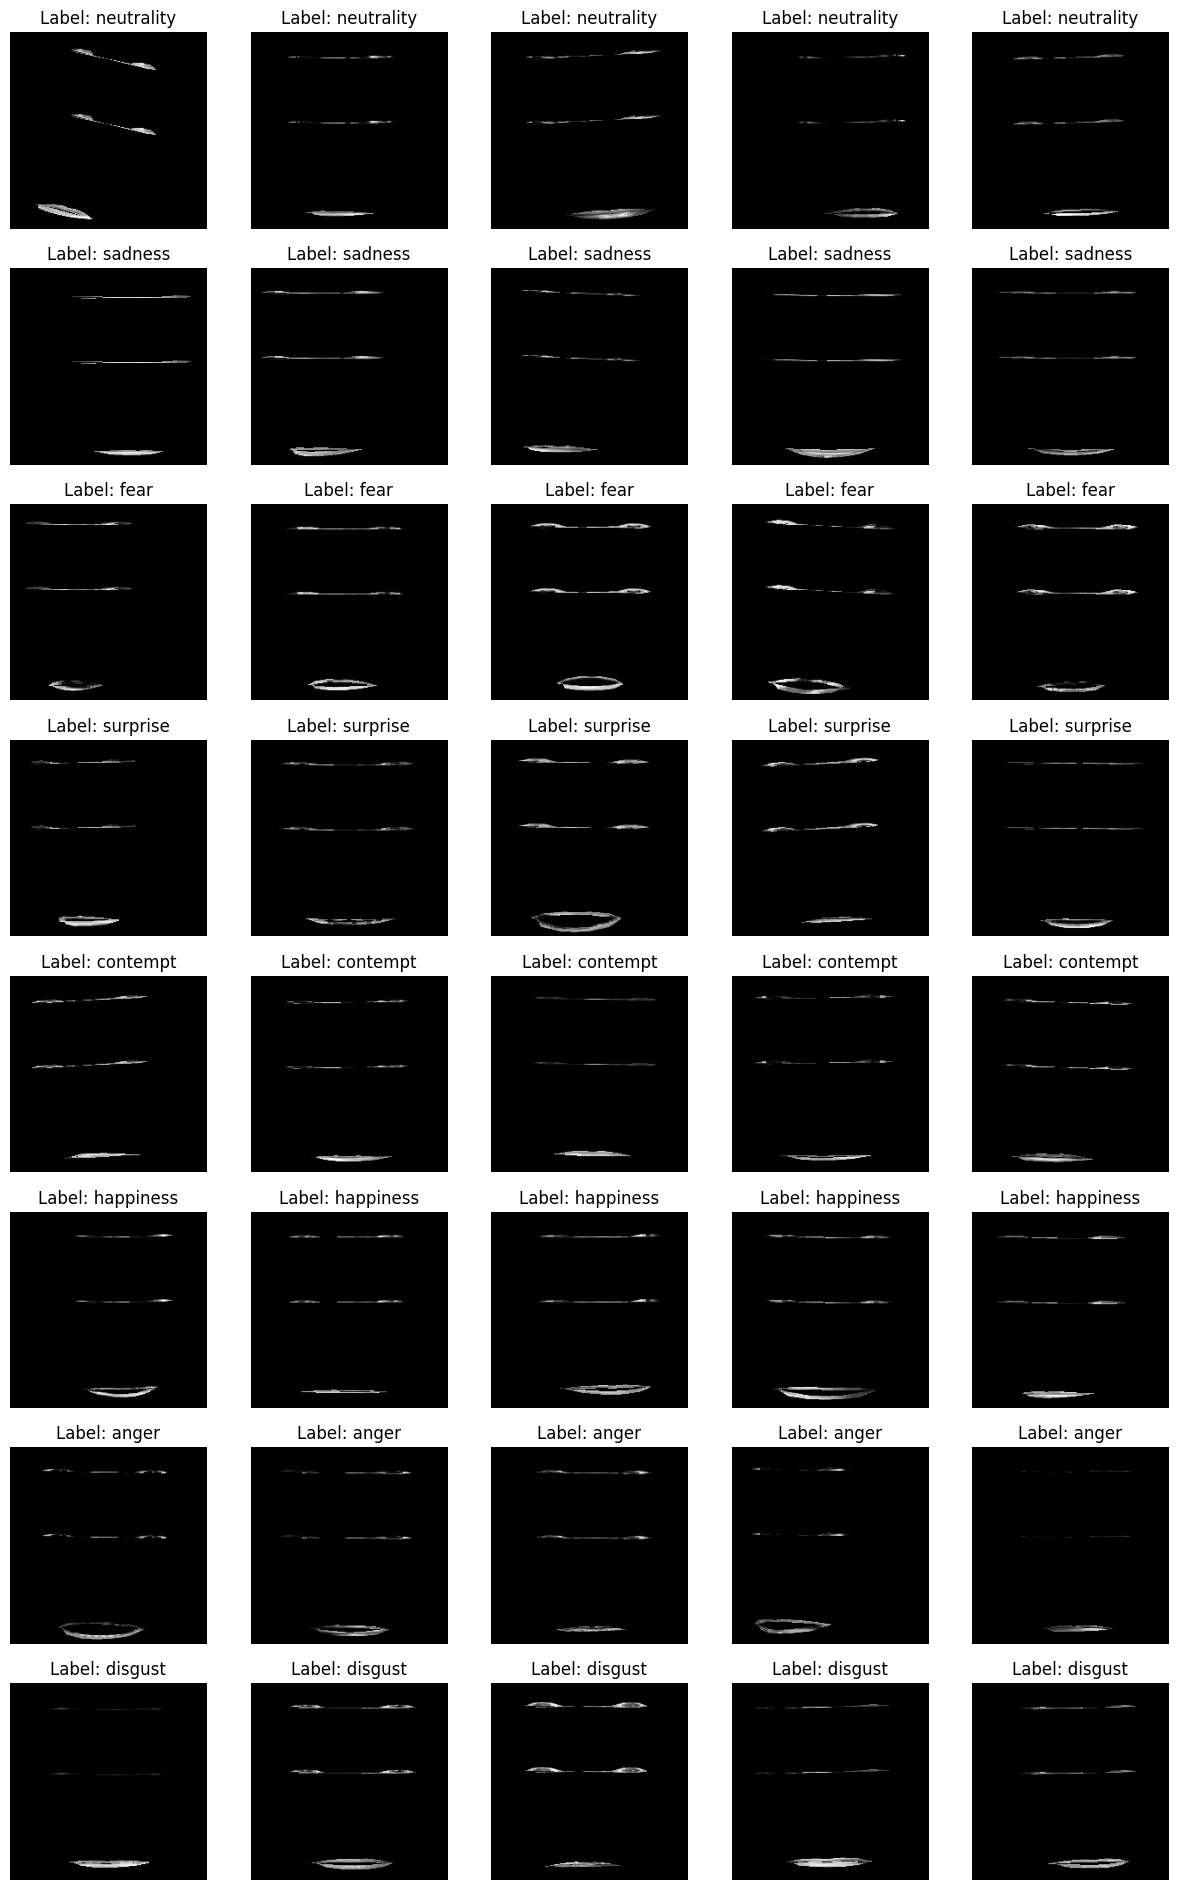

Label 0: 5 images
Label 1: 5 images
Label 2: 5 images
Label 3: 5 images
Label 4: 5 images
Label 5: 5 images
Label 6: 5 images
Label 7: 5 images


In [30]:
def plot_first_n_images(images, labels, number):
    num_labels = len(set(labels))  # Get the number of unique labels
    num_rows = (number - 1) // 5 + 1  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows * num_labels, 5, figsize=(15, 3 * num_rows * num_labels))

    label_counts = defaultdict(int)  # Keep track of the count for each label

    for i, unique_label in enumerate(set(labels)):
        images_for_label = [(img, img_label) for img, img_label in zip(images, labels) if img_label == unique_label]
        for j in range(5):
            index = i * 5 + j
            if index < number*num_labels and j < len(images_for_label):
                img, img_label = images_for_label[j]
                axes[i, j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                axes[i, j].set_title(f"Label: {classeses[img_label]}")
                axes[i, j].axis('off')

                # Increment the count for the current label
                label_counts[img_label] += 1

    plt.show()

    # Print the count for each label
    for label, count in label_counts.items():
        print(f"Label {label}: {count} images")

# Example usage
plot_first_n_images(processed_images, labels, 5)

In [31]:
# Normalize then Extract Region
def normalize_extract_facial_regions_combine(features, labels):
    processed_images = {'Processed image': []}
    failed_indices = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
     # Update with your path

    for i, image in enumerate(features):
        # Convert the image to a NumPy array
        image = linear_normalization(image)
        gray = np.array(image)
        gray_clahe = clahe.apply(gray)

        # Detect faces in the CLAHE preprocessed image
        faces = detector(gray_clahe, 1)

        # If no faces are detected with CLAHE, try standard histogram equalization
        if len(faces) == 0:
            gray_eq = cv2.equalizeHist(gray)
            faces = detector(gray_eq, 1)
            image_to_use = gray_eq
        else:
            image_to_use = gray_clahe

        # If faces are detected
        if len(faces) > 0:
            for rect in faces:
                # Determine the facial landmarks for the face region
                shape = predictor(image_to_use, rect)

                # Convert the facial landmarks to NumPy arrays
                left_eye = np.array([(shape.part(n).x, shape.part(n).y) for n in range(36, 42)])
                right_eye = np.array([(shape.part(n).x, shape.part(n).y) for n in range(42, 48)])
                left_eyebrow = np.array([(shape.part(n).x, shape.part(n).y) for n in range(17, 22)])
                right_eyebrow = np.array([(shape.part(n).x, shape.part(n).y) for n in range(22, 27)])
                mouth = np.array([(shape.part(n).x, shape.part(n).y) for n in range(48, 68)])

                # Extract regions
                eyes_region = extract_region(image, np.concatenate((left_eye, right_eye)))
                eyebrows_region = extract_region(image, np.concatenate((left_eyebrow, right_eyebrow)))
                mouth_region = extract_region(image, mouth)


                # Resize regions to match the dimensions of the destination area
                region_height, region_width= eyes_region.shape
                eyebrows_region = cv2.resize(eyebrows_region, (region_width, int(region_height / 3)))
                eyes_region = cv2.resize(eyes_region, (region_width, int(region_height / 3)))
                mouth_region = cv2.resize(mouth_region, (region_width, int(region_height-2*int(region_height*1/3))))
                region_height, region_width= eyes_region.shape

                # Combine the extracted picture
                combined_image = np.zeros_like(image_to_use)

                combined_image[:region_height, :] = eyebrows_region
                combined_image[region_height:2 * region_height, :] = eyes_region
                combined_image[2 * region_height:, :] = mouth_region

                # Append processed images and labels to the dic
                processed_images['Processed image'].append((combined_image, labels[i]))

        else:
            # If no faces are detected, add the index to the failed_indices array
            failed_indices.append(i)

    return processed_images, failed_indices

In [32]:
processed_images, nonlabels = normalize_extract_facial_regions_combine(features_or, labels_or)

In [33]:
normal_processed_images, labels = zip(*processed_images['Processed image'])

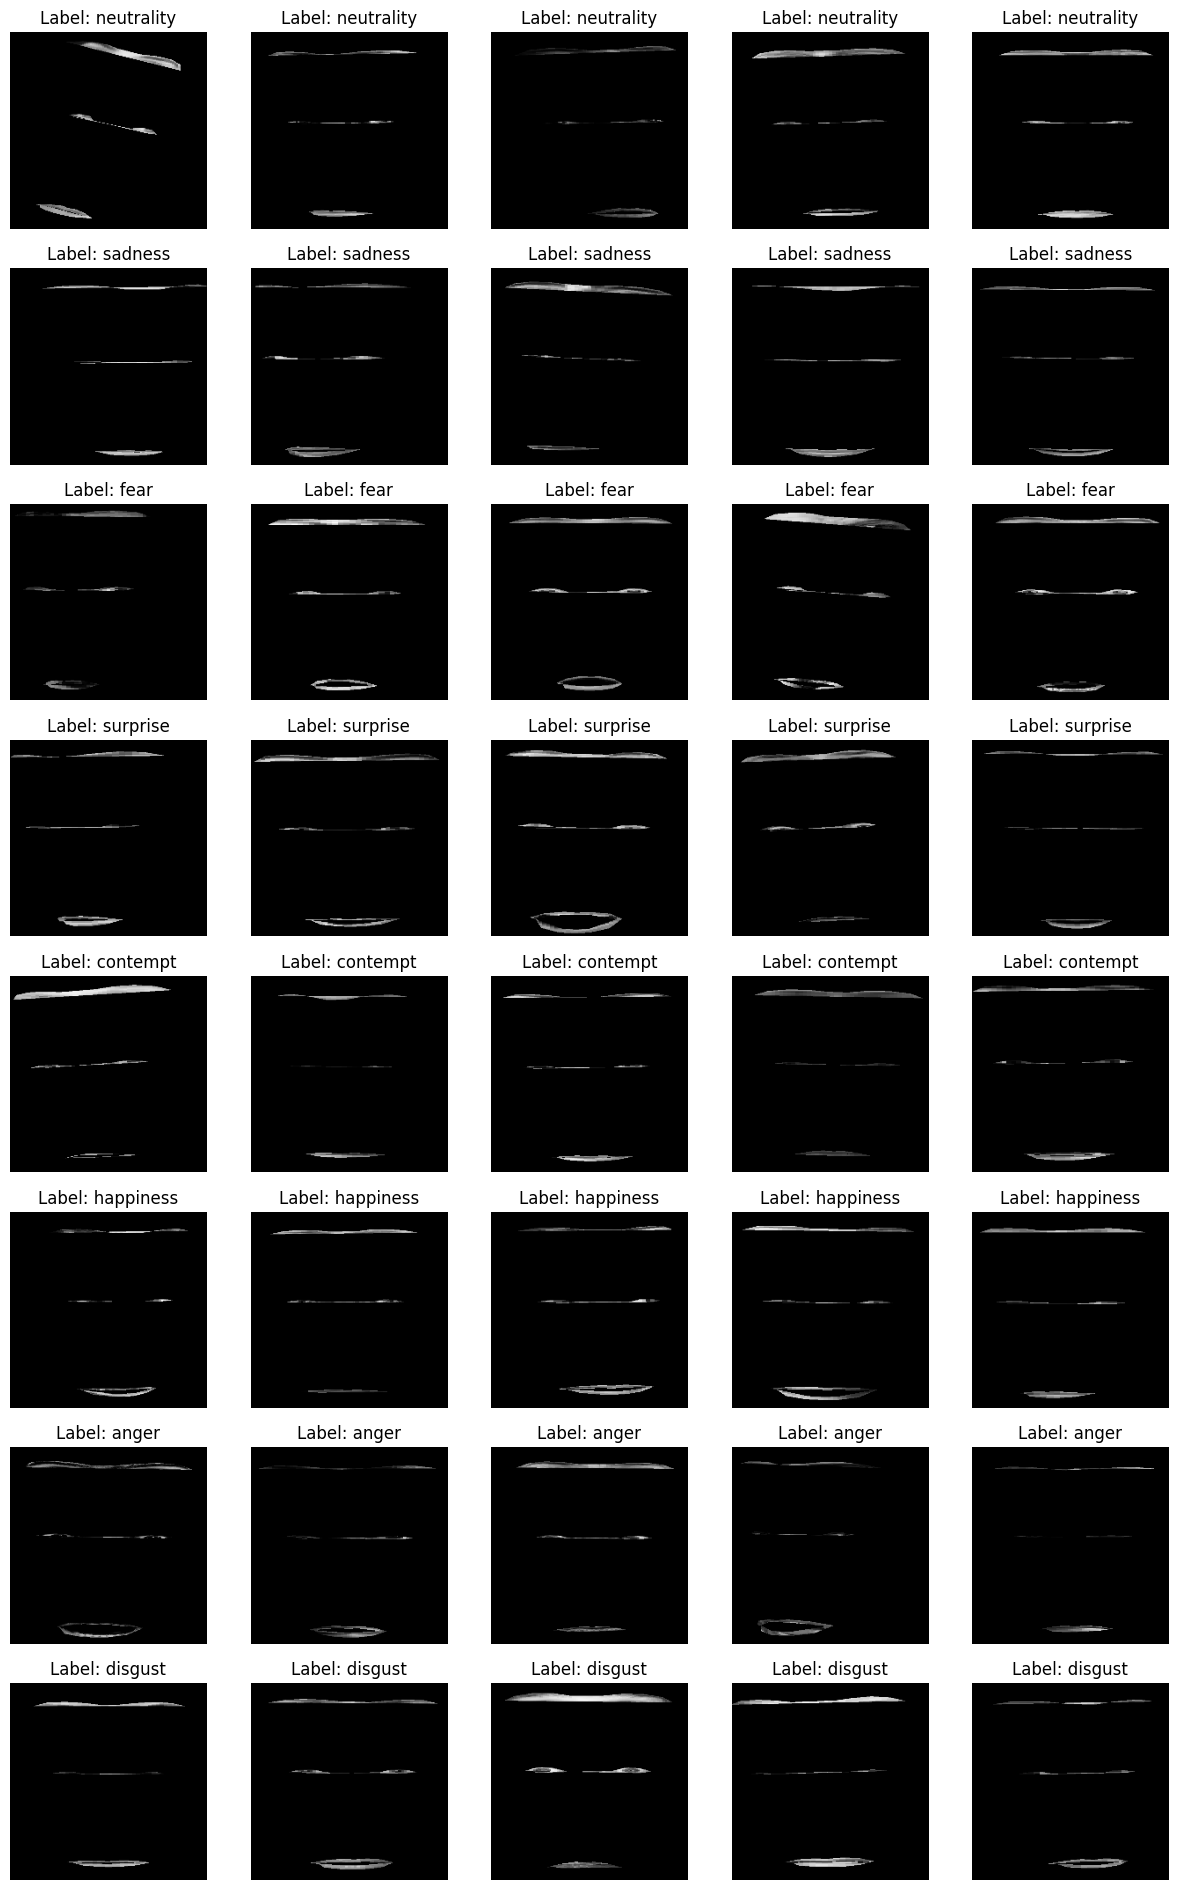

Label 0: 5 images
Label 1: 5 images
Label 2: 5 images
Label 3: 5 images
Label 4: 5 images
Label 5: 5 images
Label 6: 5 images
Label 7: 5 images


In [34]:
plot_first_n_images(normal_processed_images, labels, 5)